# LAB 4 : Multi Layered Neural Netwrok and Backpropogation  

Name : Joshitha Gandra

Roll Number : 180020009

Referrence Material : 
      
  1. **Chapter 4:, page no. 106-136, Artificial Neural Network by B. Yegnanarayana)**

  2. https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

  3. https://www.geeksforgeeks.org/deep-neural-net-with-forward-and-back-propagation-from-scratch-python/

  4. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

  5. https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

#Class for Neural Network

###Because we want our network to output probabilities the activation function for the output layer will be the softmax, which is simply a way to convert raw scores to probabilities.

###When you choose softmax as output, you can use cross-entropy loss (also known as negative log likelihood) as loss function. 



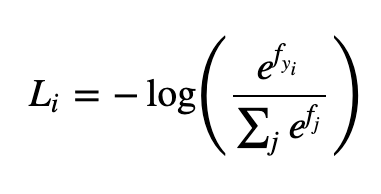

###We learn the parameters for our network (such as (W_1, b_1, W_2, b_2)) that minimize the error on our training data (loss function).

###Implement the most vanilla version of gradient descent, also called batch gradient descent with decay of the learning rate over time.

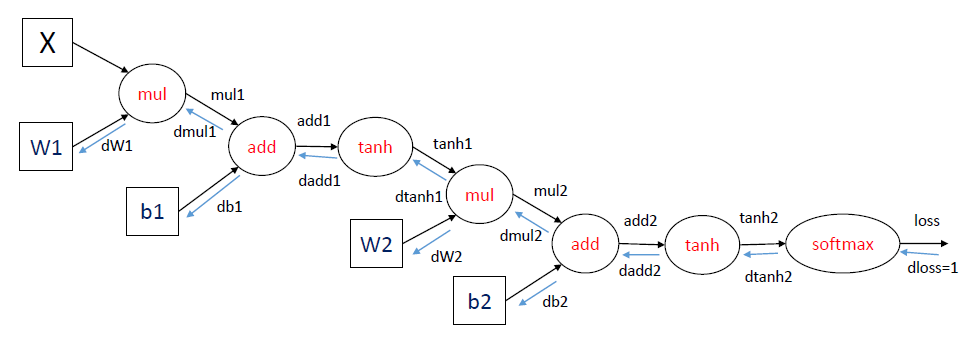

####We have multiply and add gates, and then use tanh layer and softmax 

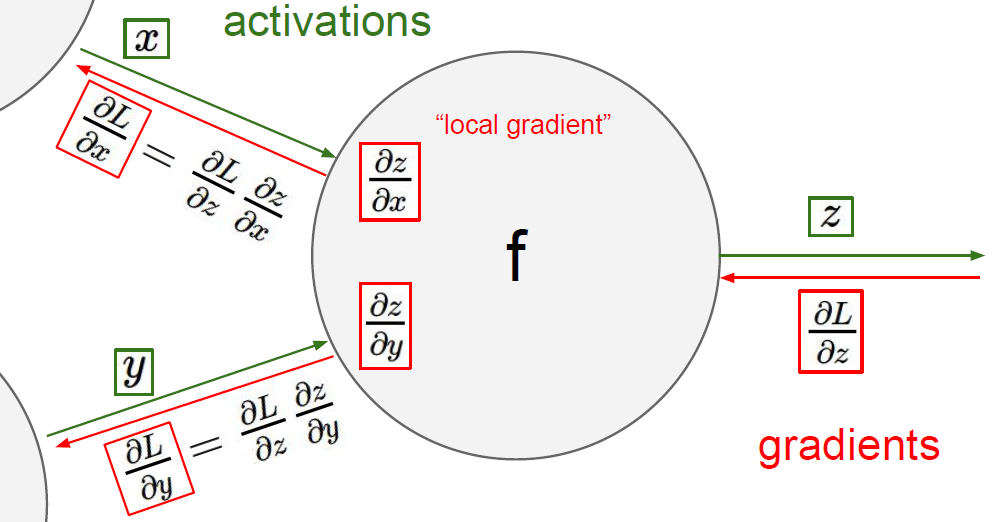

In [ ]:

class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

In [ ]:

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, grad_output):
        output = self.forward(X)
        return (1.0 - output) * output * grad_output

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, grad_output):
        output = self.forward(X)
        return (1.0 - np.square(output)) * grad_output

class ReLU:
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad

In [ ]:

class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs


In [ ]:

class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      for i in range(len(self.layers_dim)-1):
        print('weights :')
        print(self.W[i])
        print('bias :')
        print(self.b[i])
        
    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)

                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

In [ ]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import numpy as np


# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)



#Dataset-1 Moons 

##Our goal is to train a Machine Learning classifier that predicts the correct class given the x- and y- coordinates. Note that the data is not linearly separable, we can’t draw a straight line that separates the two classes. 

##This is non-convex data - A set is convex if, given any two points in the set, the line segment connecting them lies entirely inside the set.

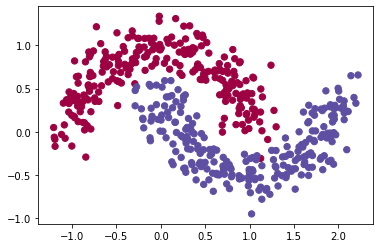

In [ ]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(500, noise=0.15)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

##Experimentation with 2 layer network

Loss after iteration 0: 0.531003
Loss after iteration 50: 0.330200
Loss after iteration 100: 0.329543
Loss after iteration 150: 0.329281
Loss after iteration 200: 0.328678
Loss after iteration 250: 0.327942


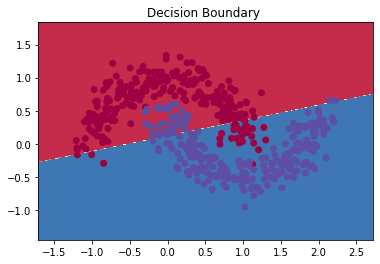

In [ ]:
layers_dim = [2, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=300, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Experimentation with 3 layer Network

Loss after iteration 0: 0.684206
Loss after iteration 50: 0.324079
Loss after iteration 100: 0.312807
Loss after iteration 150: 0.301124
Loss after iteration 200: 0.300039
Loss after iteration 250: 0.299034


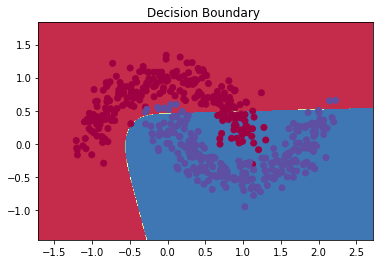

In [ ]:
layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=300, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()


Loss after iteration 0: 0.565139
Loss after iteration 50: 0.318019
Loss after iteration 100: 0.193860
Loss after iteration 150: 0.146732
Loss after iteration 200: 0.141949
Loss after iteration 250: 0.139889
Loss after iteration 300: 0.138699
Loss after iteration 350: 0.137886
Loss after iteration 400: 0.137280
Loss after iteration 450: 0.136805


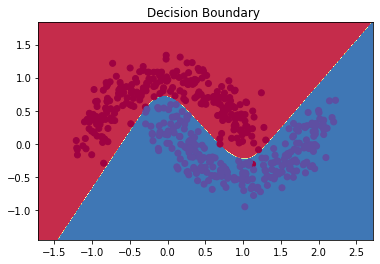

In [ ]:
layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=500, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

##Experimentation with 4 layer network

Loss after iteration 0: 0.706521
Loss after iteration 50: 0.328870
Loss after iteration 100: 0.320356
Loss after iteration 150: 0.203068
Loss after iteration 200: 0.165666
Loss after iteration 250: 0.134465
Loss after iteration 300: 0.137380
Loss after iteration 350: 0.135983
Loss after iteration 400: 0.133316
Loss after iteration 450: 0.133055


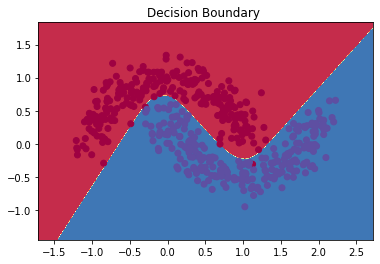

In [ ]:
layers_dim = [2, 3, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=500, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

#Dataset-2 Concentric circles

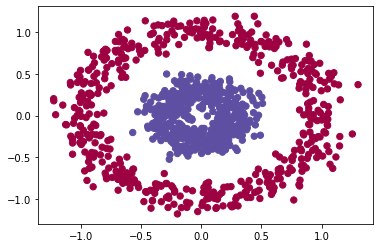

In [ ]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_circles(n_samples=1000, factor=0.3, noise=0.1, random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

##Experimentation with 3 layer neural network

Loss after iteration 0: 0.655854
Loss after iteration 50: 0.597995
Loss after iteration 100: 0.517805
Loss after iteration 150: 0.504284
Loss after iteration 200: 0.501139
Loss after iteration 250: 0.499980


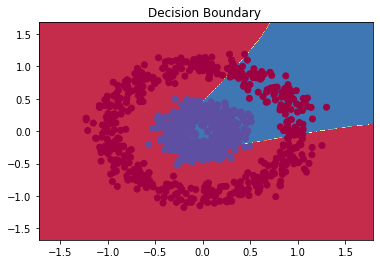

In [ ]:
layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=300, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

Loss after iteration 0: 0.693896
Loss after iteration 50: 1.108051
Loss after iteration 100: 0.146974
Loss after iteration 150: 0.139859
Loss after iteration 200: 0.137686
Loss after iteration 250: 0.136317
Loss after iteration 300: 0.135282
Loss after iteration 350: 0.134426
Loss after iteration 400: 0.133689
Loss after iteration 450: 0.133048
Loss after iteration 500: 0.132490
lr :  0.005
Loss after iteration 550: 0.132240
Loss after iteration 600: 0.132007
Loss after iteration 650: 0.131791
Loss after iteration 700: 0.131588
Loss after iteration 750: 0.131399
Loss after iteration 800: 0.131222
Loss after iteration 850: 0.131056
Loss after iteration 900: 0.130900
Loss after iteration 950: 0.130752
Loss after iteration 1000: 0.130611
lr :  0.0025
Loss after iteration 1050: 0.130544
Loss after iteration 1100: 0.130477
Loss after iteration 1150: 0.130413
Loss after iteration 1200: 0.130350
Loss after iteration 1250: 0.130288
Loss after iteration 1300: 0.130227
Loss after iteration 1350:

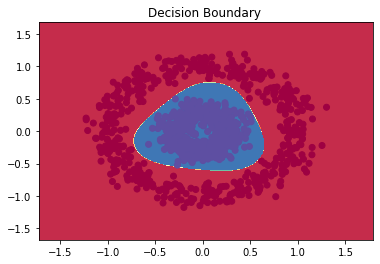

In [ ]:
layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=2000, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Experimentation with 4 layer network

Loss after iteration 0: 0.698290
Loss after iteration 50: 0.380231
Loss after iteration 100: 0.153683
Loss after iteration 150: 0.140170
Loss after iteration 200: 0.135603
Loss after iteration 250: 0.133327
Loss after iteration 300: 0.131974
Loss after iteration 350: 0.131083
Loss after iteration 400: 0.130454
Loss after iteration 450: 0.129988
Loss after iteration 500: 0.129630
lr :  0.0005
Loss after iteration 550: 0.129480
Loss after iteration 600: 0.129346
Loss after iteration 650: 0.129225
Loss after iteration 700: 0.129116
Loss after iteration 750: 0.129016
Loss after iteration 800: 0.128925
Loss after iteration 850: 0.128841
Loss after iteration 900: 0.128765
Loss after iteration 950: 0.128694


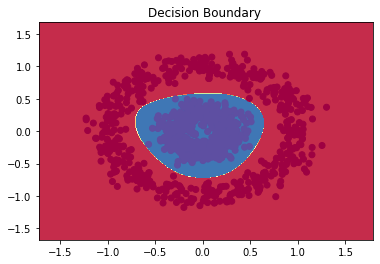

In [ ]:
layers_dim = [2, 3, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=1000, epsilon=0.001, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

#Dataset-3 4 classes non-convex data

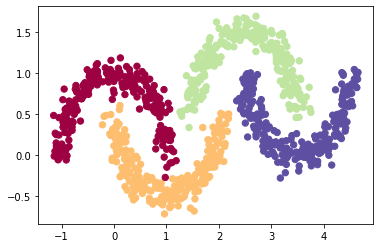

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X1,y1 = sklearn.datasets.make_moons(n_samples = 500, noise = 0.1)

X2,y2 = sklearn.datasets.make_moons(n_samples = 500, noise = 0.1)

X2[:,0] = [X2[row,0] + 2.5 for row in range(len(X2))]
X2[:,1] = [X2[row,1] + 0.5 for row in range(len(X2))]
y2 = [2 if i==0 else 3 for i in y2]

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)
y = np.array(y)

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

##Experimentation with 3 layer network

Loss after iteration 0: 1.717985
Loss after iteration 50: 0.641161
Loss after iteration 100: 0.595699
Loss after iteration 150: 0.524652
Loss after iteration 200: 0.549183
Loss after iteration 250: 0.486589
Loss after iteration 300: 0.491315
Loss after iteration 350: 0.498178
Loss after iteration 400: 0.491013
Loss after iteration 450: 0.502262


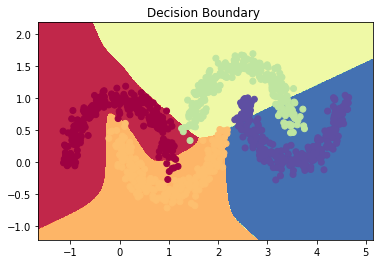

In [ ]:
layers_dim = [2, 6, 4]

model = Model(layers_dim)
model.train(X, y, num_passes=500, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

Loss after iteration 0: 1.576784
Loss after iteration 50: 0.630184
Loss after iteration 100: 0.538830
Loss after iteration 150: 0.562934
Loss after iteration 200: 0.466788
Loss after iteration 250: 0.462753
Loss after iteration 300: 0.461184
Loss after iteration 350: 0.454756
Loss after iteration 400: 0.453366
Loss after iteration 450: 0.452578
Loss after iteration 500: 0.452348
lr :  0.005
Loss after iteration 550: 0.436223
Loss after iteration 600: 0.434920
Loss after iteration 650: 0.433127
Loss after iteration 700: 0.430564
Loss after iteration 750: 0.427863
Loss after iteration 800: 0.450435
Loss after iteration 850: 0.441008
Loss after iteration 900: 0.439912
Loss after iteration 950: 0.430083
Loss after iteration 1000: 0.427351
lr :  0.0025
Loss after iteration 1050: 0.426055
Loss after iteration 1100: 0.424861
Loss after iteration 1150: 0.423807
Loss after iteration 1200: 0.422920
Loss after iteration 1250: 0.429049
Loss after iteration 1300: 0.428684
Loss after iteration 1350:

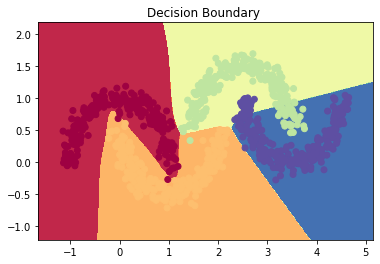

In [ ]:
layers_dim = [2, 6, 4]

model = Model(layers_dim)
model.train(X, y, num_passes=2000, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Experimentation with 3 layer network, increased neurons in hidden layer

Loss after iteration 0: 1.201952
Loss after iteration 50: 0.541815
Loss after iteration 100: 0.461551
Loss after iteration 150: 0.436270
Loss after iteration 200: 0.439289
Loss after iteration 250: 0.427187
Loss after iteration 300: 0.419979
Loss after iteration 350: 0.415176
Loss after iteration 400: 0.420996
Loss after iteration 450: 0.413012
Loss after iteration 500: 0.403971
lr :  0.005
Loss after iteration 550: 0.394489
Loss after iteration 600: 0.392854
Loss after iteration 650: 0.390567
Loss after iteration 700: 0.388399
Loss after iteration 750: 0.391245
Loss after iteration 800: 0.393094
Loss after iteration 850: 0.389899
Loss after iteration 900: 0.386816
Loss after iteration 950: 0.384098
Loss after iteration 1000: 0.384742
lr :  0.0025
Loss after iteration 1050: 0.365343
Loss after iteration 1100: 0.354445
Loss after iteration 1150: 0.352571
Loss after iteration 1200: 0.351368
Loss after iteration 1250: 0.350436
Loss after iteration 1300: 0.349625
Loss after iteration 1350:

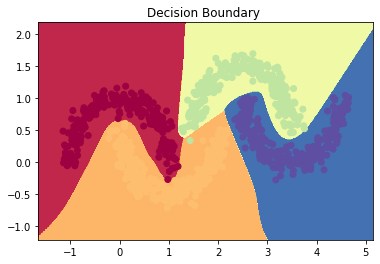

In [ ]:
layers_dim = [2, 16, 4]

model = Model(layers_dim)
model.train(X, y, num_passes=2000, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Experimentation with 4 layer network

Loss after iteration 0: 1.090223
Loss after iteration 50: 0.789676
Loss after iteration 100: 0.661186
Loss after iteration 150: 0.494326
Loss after iteration 200: 0.433325
Loss after iteration 250: 0.399443
Loss after iteration 300: 0.403491
Loss after iteration 350: 0.407538
Loss after iteration 400: 0.440108
Loss after iteration 450: 0.422868
Loss after iteration 500: 0.421410
lr :  0.005
Loss after iteration 550: 0.394768
Loss after iteration 600: 0.380692
Loss after iteration 650: 0.372804
Loss after iteration 700: 0.366153
Loss after iteration 750: 0.368264
Loss after iteration 800: 0.357623
Loss after iteration 850: 0.358988
Loss after iteration 900: 0.367245
Loss after iteration 950: 0.354311
Loss after iteration 1000: 0.347850
lr :  0.0025
Loss after iteration 1050: 0.346715
Loss after iteration 1100: 0.345149
Loss after iteration 1150: 0.344780
Loss after iteration 1200: 0.344151
Loss after iteration 1250: 0.343621
Loss after iteration 1300: 0.343704
Loss after iteration 1350:

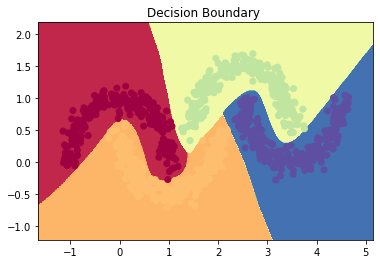

In [ ]:
layers_dim = [2, 16, 8, 4]

model = Model(layers_dim)
model.train(X, y, num_passes=3000, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

#**Experiment using different activation function - sigmoid**


##Model with sigmoid activation

In [ ]:
class Model_with_sigmoid_act:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)

                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

##Concentric circles dataset

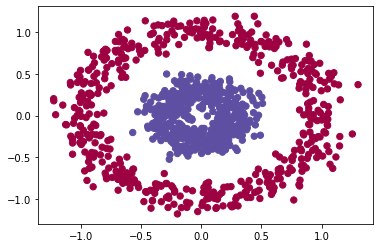

In [ ]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_circles(n_samples=1000, factor=0.3, noise=0.1, random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

##Experimentation with 3 layer neural network

Loss after iteration 0: 0.697033
Loss after iteration 50: 0.627067
Loss after iteration 100: 0.518018
Loss after iteration 150: 0.489382


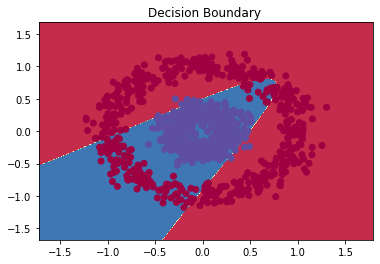

In [ ]:
layers_dim = [2, 3, 2]

model = Model_with_sigmoid_act(layers_dim)
model.train(X, y, num_passes=200, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

In [ ]:
W,b = model.print_weights()

for i in range(len(layers_dim)-1):
        print('weights :')
        print(W[i])
        print('bias :')
        print(b[i])

weights :
[[-4.09598965 -1.31406624  7.68648946]
 [ 7.33650529 -1.83930387 -3.87789402]]
bias :
[[-3.74923473 -1.36423801 -3.87901732]]
weights :
[[ 7.25246771 -6.95331036]
 [ 0.61059748 -1.79067248]
 [ 7.30175455 -6.93405732]]
bias :
[[-3.54902594  3.40254992]]


Loss after iteration 0: 0.683598
Loss after iteration 50: 0.693258
Loss after iteration 100: 0.692921
Loss after iteration 150: 0.597930
Loss after iteration 200: 0.503772
Loss after iteration 250: 0.332343
Loss after iteration 300: 0.313799
Loss after iteration 350: 0.145388
Loss after iteration 400: 0.136386
Loss after iteration 450: 0.134441
Loss after iteration 500: 0.133470
lr :  0.005
Loss after iteration 550: 0.133134
Loss after iteration 600: 0.132858
Loss after iteration 650: 0.132624
Loss after iteration 700: 0.132421
Loss after iteration 750: 0.132244
Loss after iteration 800: 0.132086
Loss after iteration 850: 0.131944
Loss after iteration 900: 0.131816
Loss after iteration 950: 0.131699


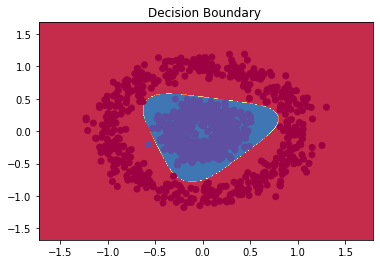

In [ ]:
layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=1000, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Experimentation with 4 layer network

Loss after iteration 0: 0.685409
Loss after iteration 50: 0.403079
Loss after iteration 100: 0.389861
Loss after iteration 150: 0.378308
Loss after iteration 200: 0.176533
Loss after iteration 250: 0.143135
Loss after iteration 300: 0.137511
Loss after iteration 350: 0.134941
Loss after iteration 400: 0.133397
Loss after iteration 450: 0.132344
Loss after iteration 500: 0.131574
lr :  0.0005
Loss after iteration 550: 0.131261
Loss after iteration 600: 0.130985
Loss after iteration 650: 0.130739
Loss after iteration 700: 0.130519
Loss after iteration 750: 0.130320
Loss after iteration 800: 0.130141
Loss after iteration 850: 0.129978
Loss after iteration 900: 0.129828
Loss after iteration 950: 0.129692


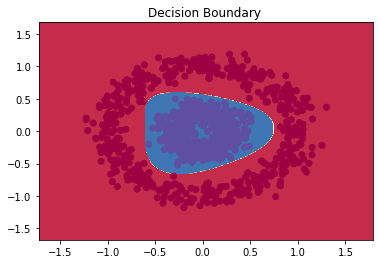

In [ ]:
layers_dim = [2, 3, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=1000, epsilon=0.001, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

#Inference ans conclusion

####4 layered Neural Network (2 hidden layers) can classify non-convex data
####3 layered neural network though initially couldn't classify the data correctly, after adjusting number of neurons in the hidden layer, lr and decay (tuning hyperparameters) was able to learn appropriate decision boundary.

#Step 4

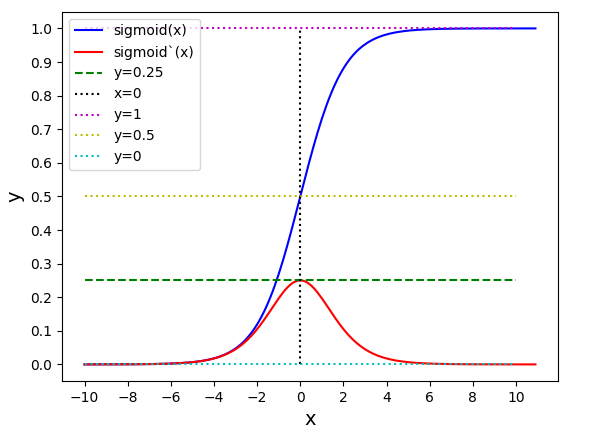

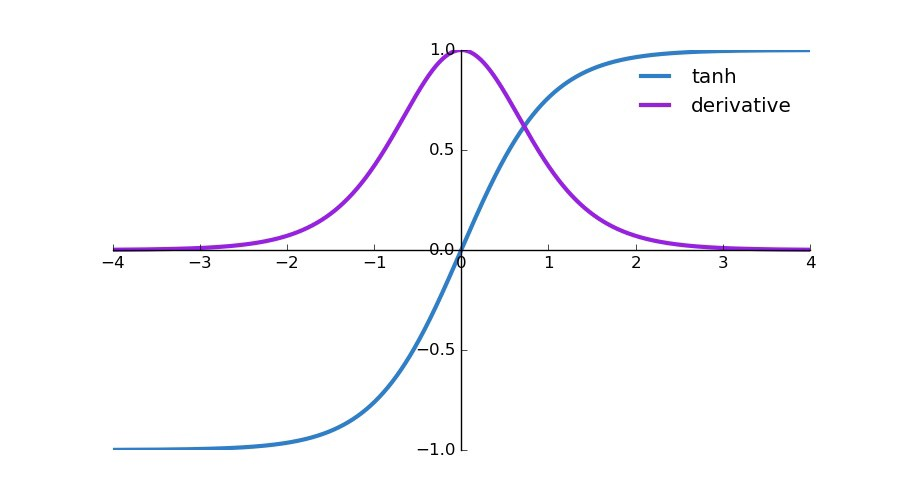

Vanishing Gradient

In vanishing gradient, the gradient becomes very small (close to 0) which leads to a very small change in weights (or almost no change).

he maximum value of the derivative of sigmoid is 0.25 and the minimum is 0. The maximum value is less than 1. Many times multiplication of smaller numbers results in a very small number (close to 0). So this is how vanishing gradient is happening in a neural network (NN) with sigmoid activations. If NN is deep and all activations are sigmoid, then there is a very high chance of vanishing gradient

##The gradient vanishing using sigmoid activation



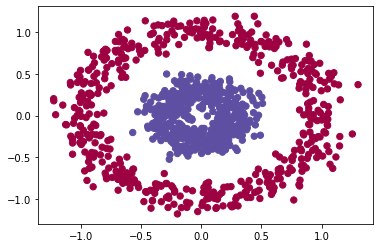

In [ ]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_circles(n_samples=1000, factor=0.3, noise=0.1, random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

###problem

In [ ]:
class Model_with_sigmoid_act2:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Sigmoid()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                if(epoch%1000==0):
                  print('\n')
                  print(dW)
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)



[[ 6.85162722 -5.59639613]
 [-0.29888419 -0.17589468]
 [ 4.98309308 -4.12804547]]


[[-0.06845099 -0.55166673 -0.06363839]
 [-0.14476158 -2.79575717 -0.15811921]]
Loss after iteration 0: 0.692023
Loss after iteration 50: 0.610419
Loss after iteration 100: 0.514162
Loss after iteration 150: 0.485698
Loss after iteration 200: 0.472446
Loss after iteration 250: 0.458290
Loss after iteration 300: 0.385545
Loss after iteration 350: 0.358918
Loss after iteration 400: 0.348510
Loss after iteration 450: 0.342537
Loss after iteration 500: 0.338621
lr :  0.001
Loss after iteration 550: 0.338301
Loss after iteration 600: 0.337992
Loss after iteration 650: 0.337693
Loss after iteration 700: 0.337403
Loss after iteration 750: 0.337122
Loss after iteration 800: 0.336849
Loss after iteration 850: 0.336584
Loss after iteration 900: 0.336327
Loss after iteration 950: 0.336077


[[ 0.69058561 -0.67789882]
 [-0.44290447  0.41718387]
 [ 0.69353903 -0.67991471]]


[[-0.36575958 -0.14977767  0.33118658]
 

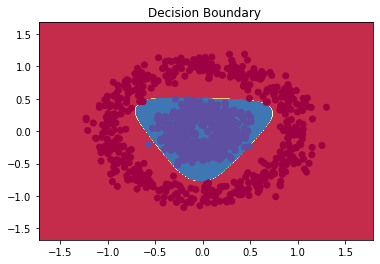

In [ ]:
layers_dim = [2, 3, 2]

model = Model_with_sigmoid_act2(layers_dim)
model.train(X, y, num_passes=1001, epsilon=0.01, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()



[[ 0.4068904  -0.40526866]
 [ 0.45854597 -0.45909784]
 [ 0.64485348 -0.6448697 ]]


[[ 0.06662068 -0.07456613  0.06438523]
 [ 0.11048033 -0.12543956  0.11038419]
 [ 0.02991577 -0.03117448  0.0264469 ]
 [ 0.04513057 -0.0466943   0.04139149]]


[[-0.00622574 -0.01376698  0.01226171 -0.00573609]
 [-0.00589434 -0.0349905   0.01202376 -0.0052417 ]
 [-0.00201446  0.03838506  0.00301156 -0.00212867]]


[[ 0.00972363 -0.04071009  0.00564524]
 [ 0.00532931 -0.04645891  0.00674062]]
Loss after iteration 0: 0.693121
Loss after iteration 50: 0.693101
Loss after iteration 100: 0.693099
Loss after iteration 150: 0.693096
Loss after iteration 200: 0.693094
Loss after iteration 250: 0.693092
Loss after iteration 300: 0.693090
Loss after iteration 350: 0.693087
Loss after iteration 400: 0.693084
Loss after iteration 450: 0.693082
Loss after iteration 500: 0.693079
lr :  0.0001
Loss after iteration 550: 0.693078
Loss after iteration 600: 0.693078
Loss after iteration 650: 0.693078
Loss after iteration

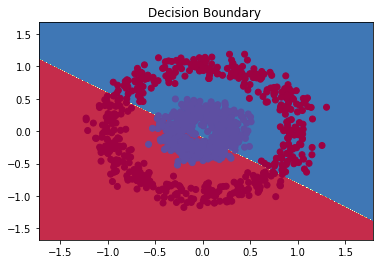

In [ ]:
layers_dim = [2, 3, 4, 3, 2]

model = Model_with_sigmoid_act2(layers_dim)
model.train(X, y, num_passes=2001, epsilon=0.001, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

##Using Tanh

Loss after iteration 0: 0.615406
Loss after iteration 50: 0.167187
Loss after iteration 100: 0.135676
Loss after iteration 150: 0.131008
Loss after iteration 200: 0.129501
Loss after iteration 250: 0.128794
Loss after iteration 300: 0.128388
Loss after iteration 350: 0.128125
Loss after iteration 400: 0.127942
Loss after iteration 450: 0.127807
Loss after iteration 500: 0.127703
lr :  0.0001
Loss after iteration 550: 0.127694
Loss after iteration 600: 0.127685
Loss after iteration 650: 0.127676
Loss after iteration 700: 0.127668
Loss after iteration 750: 0.127660
Loss after iteration 800: 0.127652
Loss after iteration 850: 0.127644
Loss after iteration 900: 0.127636
Loss after iteration 950: 0.127628
Loss after iteration 1000: 0.127621
lr :  1e-05
Loss after iteration 1050: 0.127620
Loss after iteration 1100: 0.127620
Loss after iteration 1150: 0.127619
Loss after iteration 1200: 0.127618
Loss after iteration 1250: 0.127617
Loss after iteration 1300: 0.127617
Loss after iteration 1350:

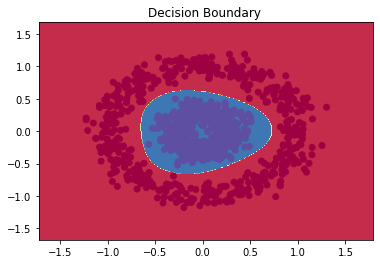

In [ ]:
layers_dim = [2, 3, 4, 3, 2]

model = Model(layers_dim)

model.train(X, y, num_passes=2000, epsilon=0.001, lr_decay=0.1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

###Models

In [ ]:
class LeekyReLU():
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0.1*input,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        for i in range(len(input)):
          for j in range(len(input[i])):
            if (input[i][j]>0):
              relu_grad[i][j] = 1
            else:
              relu_grad[i][j] = 0.1
        return grad_output*relu_grad

In [ ]:
class Model_with_ReLU:
    def __init__(self, layers_dim, param):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i])*param)
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                if(epoch%1000==0):
                  print('\n')
                  print(dW)
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

In [ ]:
class Model_with_LeekyReLU:
    def __init__(self, layers_dim, param):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i])*param)
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                if(epoch%1000==0):
                  print('\n')
                  print(dW)
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

###Training

Loss after iteration 0: 2.657358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Loss after iteration 50: nan
Loss after iteration 100: nan
Loss after iteration 150: nan
Loss after iteration 200: nan
Loss after iteration 250: nan
Loss after iteration 300: nan
Loss after iteration 350: nan
Loss after iteration 400: nan
Loss after iteration 450: nan


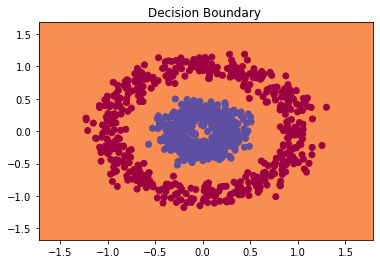

In [ ]:
layers_dim = [2, 5, 5, 5, 5, 2]

model = Model_with_LeekyReLU(layers_dim, 0.1)

model.train(X, y, num_passes=500, epsilon=0.01, lr_decay=1, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

ReLU is an activation function that is well-known for mitigating the vanishing gradient problem, but it also makes it simple to generate exploding gradients

##Exploding gradient

In the exploding gradient, gradient value becomes very large and this leads to too much variation in updated weights (undesired). 

###Models

In [ ]:
class LeekyReLU():
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0.1*input,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        for i in range(len(input)):
          for j in range(len(input[i])):
            if (input[i][j]>0):
              relu_grad[i][j] = 1
            else:
              relu_grad[i][j] = 0.1
        return grad_output*relu_grad

In [ ]:
class Model_with_ReLU:
    def __init__(self, layers_dim, param):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i])*param*10)
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = ReLU()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                if(epoch%1000==0 and epoch>0):
                  print('\n')
                  print(dW)
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

In [ ]:
class Model_with_LeekyReLU:
    def __init__(self, layers_dim, param):
        self.b = []
        self.W = []
        self.layers_dim = layers_dim
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i])*param*10)
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def print_weights(self):
      return self.W, self.b

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, lr_decay=0.5, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = LeekyReLU()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                if(epoch%1000==0 and epoch>0):
                  print('\n')
                  print(dW)
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 50 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

            if epoch > 0 and epoch % 500 == 0:
                epsilon = epsilon*lr_decay
                print("lr : ", epsilon)

###Training

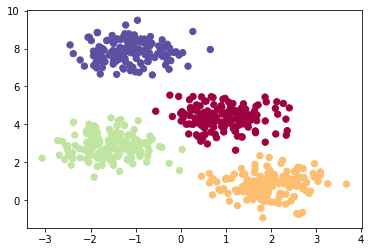

In [ ]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_blobs(n_samples=600, centers=4, n_features=2, cluster_std=0.60, random_state=0)

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Loss after iteration 0: nan
Loss after iteration 50: nan
Loss after iteration 100: nan
Loss after iteration 150: nan
Loss after iteration 200: nan
Loss after iteration 250: nan
Loss after iteration 300: nan
Loss after iteration 350: nan
Loss after iteration 400: nan
Loss after iteration 450: nan


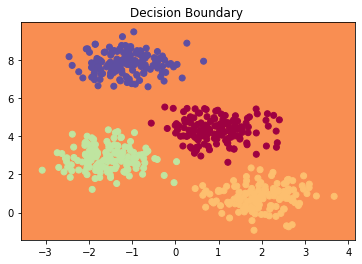

In [ ]:
layers_dim = [2, 4, 4, 4]

model = Model_with_LeekyReLU(layers_dim, 1)

model.train(X, y, num_passes=500, epsilon=0.01, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

Loss after iteration 0: 1.363119
Loss after iteration 50: 0.141686
Loss after iteration 100: 0.084042
Loss after iteration 150: 0.062013
Loss after iteration 200: 0.050878
Loss after iteration 250: 0.044158
Loss after iteration 300: 0.039769
Loss after iteration 350: 0.036784
Loss after iteration 400: 0.034563
Loss after iteration 450: 0.032768
Loss after iteration 500: 0.031035
lr :  0.0005
Loss after iteration 550: 0.030300
Loss after iteration 600: 0.029634
Loss after iteration 650: 0.028939
Loss after iteration 700: 0.028208
Loss after iteration 750: 0.027475
Loss after iteration 800: 0.026712
Loss after iteration 850: 0.025957
Loss after iteration 900: 0.025212
Loss after iteration 950: 0.024404


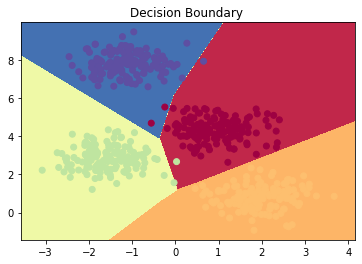

In [ ]:
layers_dim = [2, 4, 4]

model = Model_with_LeekyReLU(layers_dim, 0.1)

model.train(X, y, num_passes=1000, epsilon=0.001, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

Loss after iteration 0: 1.488576
Loss after iteration 50: 0.464160
Loss after iteration 100: 0.400948
Loss after iteration 150: 0.384320
Loss after iteration 200: 0.376555
Loss after iteration 250: 0.371890
Loss after iteration 300: 0.368545
Loss after iteration 350: 0.365903
Loss after iteration 400: 0.363803
Loss after iteration 450: 0.362118
Loss after iteration 500: 0.360705
lr :  0.0005
Loss after iteration 550: 0.360052
Loss after iteration 600: 0.359403
Loss after iteration 650: 0.358717
Loss after iteration 700: 0.357824
Loss after iteration 750: 0.356704
Loss after iteration 800: 0.355617
Loss after iteration 850: 0.354544
Loss after iteration 900: 0.353526
Loss after iteration 950: 0.352601
Loss after iteration 1000: 0.351791
lr :  0.00025
Loss after iteration 1050: 0.351430
Loss after iteration 1100: 0.351098
Loss after iteration 1150: 0.350791
Loss after iteration 1200: 0.350509
Loss after iteration 1250: 0.350248
Loss after iteration 1300: 0.350006
Loss after iteration 135

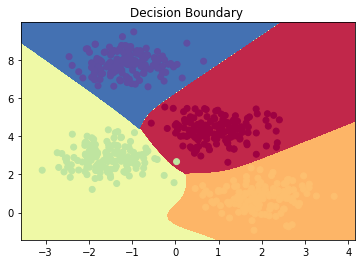

In [ ]:
layers_dim = [2, 4, 4, 4]

model = Model(layers_dim)

model.train(X, y, num_passes=2000, epsilon=0.001, lr_decay=0.5, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary ")
plt.show()

# Inferences and Conclusion : State all the key observations and conclusion

using sigmoid activation -> demonstrated vanishing gradient.

rectification: relu, tanh

relu -> exploding gradient explained

rectification: small weight initialization, tanh

#Vanishing Gradient problem:

####As more layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero, making the network hard to train.

####Certain activation functions, like the sigmoid function, squishes a large input space into a small input space between 0 and 1. Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Hence, the derivative becomes small

#Solutions:

1. The simplest solution is to use other activation functions, such as ReLU, which doesn’t cause a small derivative.
2. Redesigning the network to have fewer layers.


#How do You Know if You Have Exploding Gradients?

1. The model weights quickly become very large during training.
2. The model weights go to NaN values during training.
3. The error gradient values are consistently > 1 during training

#How to Fix Exploding Gradients?

1. Redesigning the network to have fewer layers.
2. Gradient Clipping can be used - check for and limit the size of gradients during the training of your network.
3. check weight initialization

###ReLU is an activation function that is well-known for mitigating the vanishing gradient problem, but it also makes it simple to generate exploding gradients if the weights are large enough, which is why weights must be initialized to very small values.